## Workspace setup

In [1]:
from datetime import datetime  
import importlib
import uproot
from functools import partial
import numpy as np
import tensorflow as tf

2023-05-05 10:40:24.076705: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Training dataset preparation

2023-05-05 10:40:28.996326: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-05 10:40:29.002397: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-05 10:40:29.002509: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

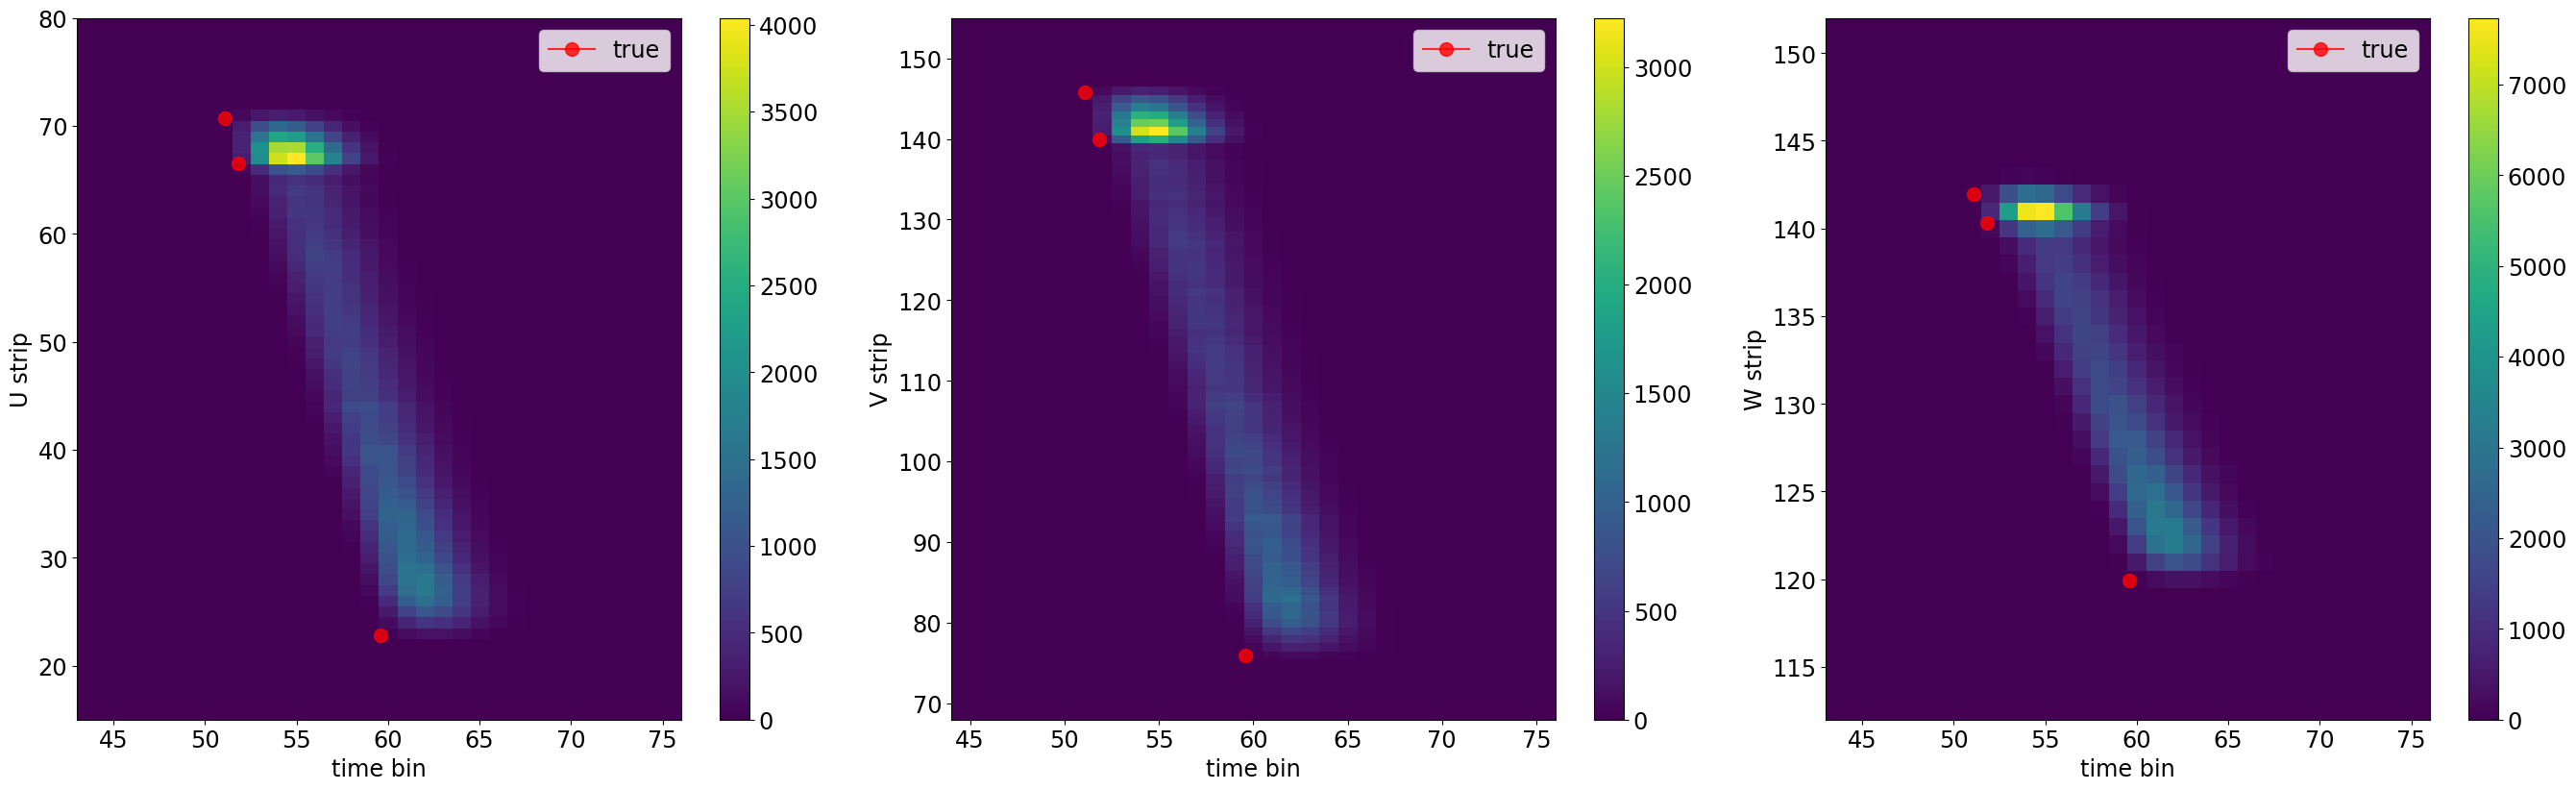

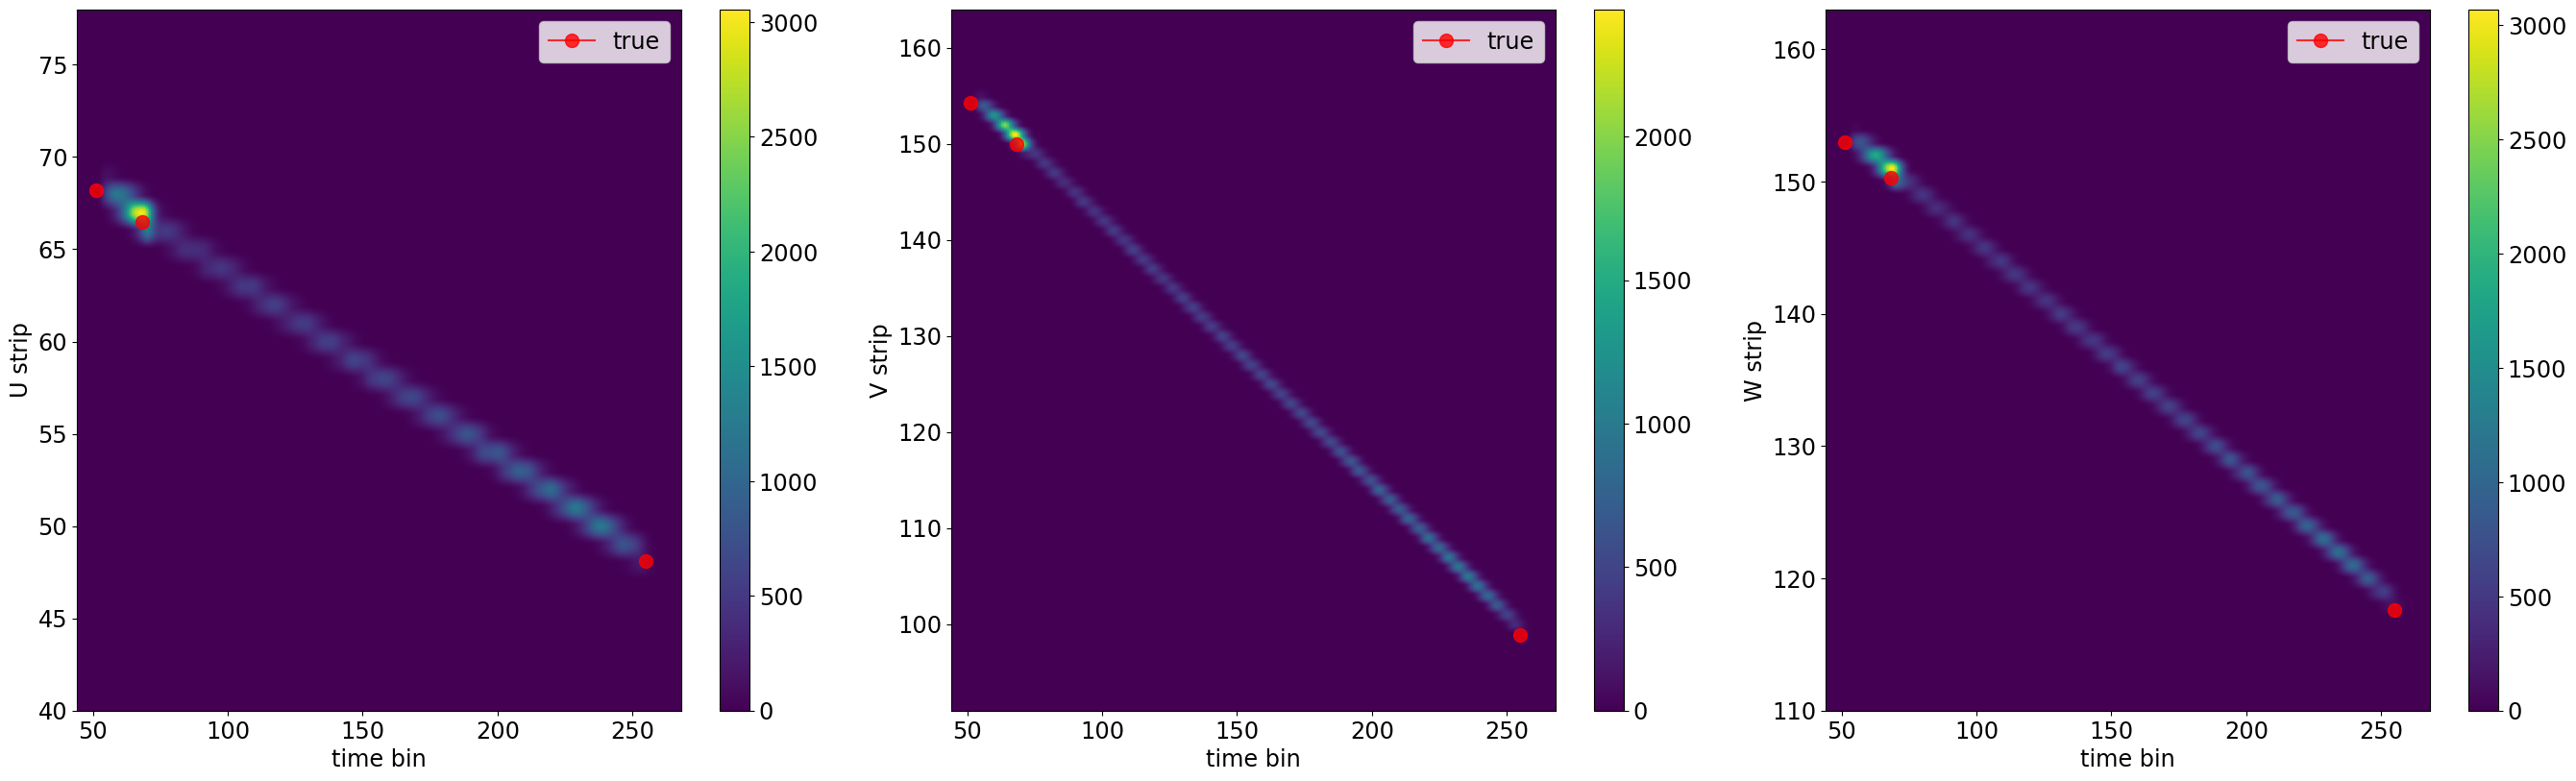

In [2]:
import io_functions as io
importlib.reload(io)

import plotting_functions as plf
importlib.reload(plf)

train_files = ['data/out_C_arr_1.root:TPCData','data/out_C_arr_2.root:TPCData', 'data/out_C_arr_3.root:TPCData', 'data/out_C_arr_4.root:TPCData']
datasetGenerator = partial(io.generator, files=train_files)

train_dataset = tf.data.Dataset.from_generator(
     datasetGenerator,
     output_signature=(
         tf.TensorSpec(shape=(io.projections.shape), dtype=tf.int32),
         tf.TensorSpec(shape=(9), dtype=tf.float64)))

for aBatch in train_dataset.batch(1).take(1):
    plf.plotEvent(aBatch, model=None)

test_files = ['data/out_C_arr_5.root:TPCData']
datasetGenerator = partial(io.generator, files=test_files)

test_dataset = tf.data.Dataset.from_generator(
     datasetGenerator,
     output_signature=(
         tf.TensorSpec(shape=(io.projections.shape), dtype=tf.int32),
         tf.TensorSpec(shape=(9), dtype=tf.float64)))
 
for aBatch in test_dataset.batch(1).take(1):
    plf.plotEvent(aBatch, model=None)

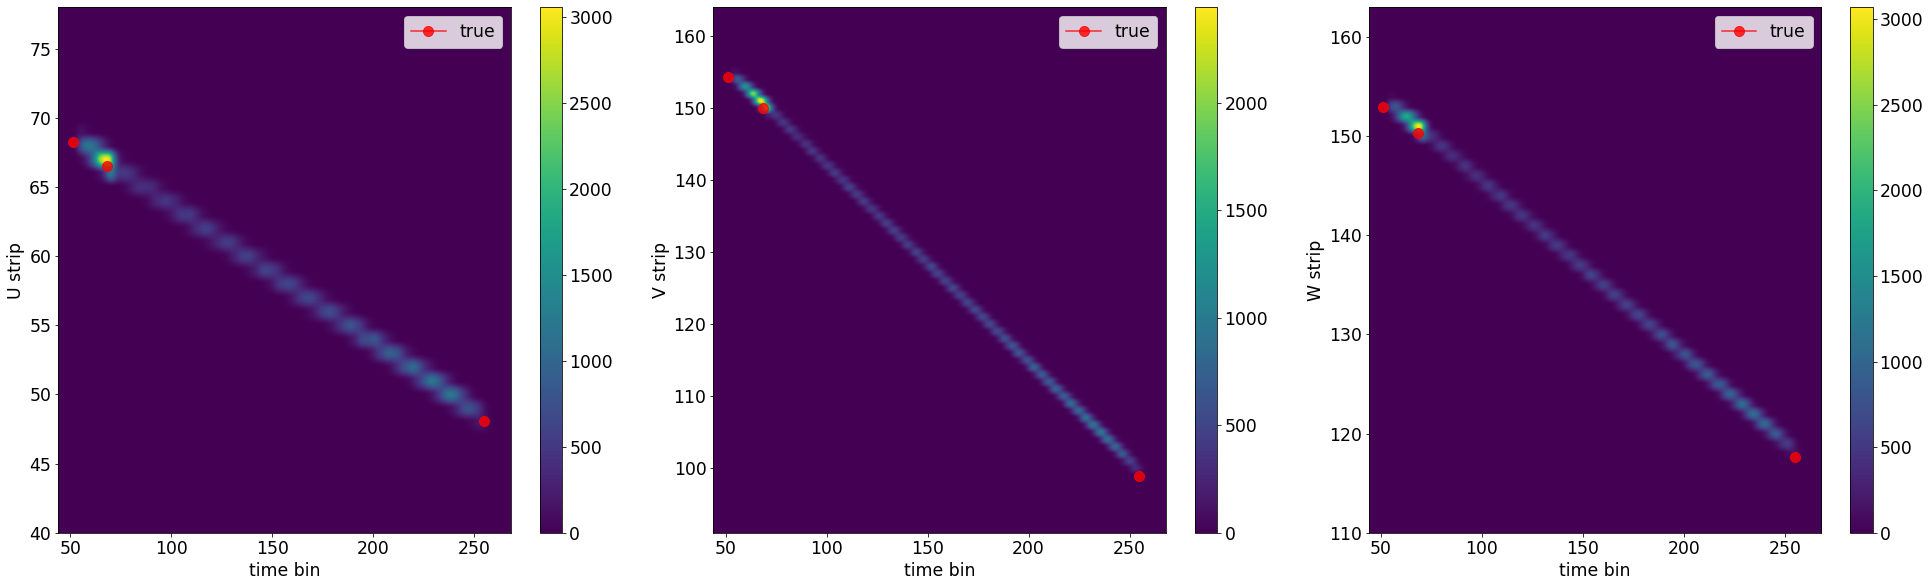

In [3]:
import plotting_functions as plf
importlib.reload(plf)

import utility_functions as utils
importlib.reload(utils)

for aBatch in test_dataset.batch(1).take(1):
    plf.plotEvent(aBatch, model=None)

## Model definition

In [4]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./10000, input_shape=io.projections.shape),
  #tf.keras.layers.LayerNormalization(axis=-1 , center=True , scale=True),
  tf.keras.layers.Resizing(height=128, width=128), 
  tf.keras.layers.Conv2D(16, 5, padding='same', activation='relu', 
                         data_format="channels_last"),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 5, padding='same', activation='relu', 
                         data_format="channels_last"),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 5, padding='same', activation='relu', 
                         data_format="channels_last"),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'), 
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(9)
])

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                decay_steps=5000,
                decay_rate=0.98,
                staircase=False)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule) 
model.compile(optimizer = optimizer, 
              loss = 'mse', 
              metrics=['mse']) 

## Model training

2023-05-05 09:39:00.817399: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2023-05-05 09:39:00.817422: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2023-05-05 09:39:00.960441: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2023-05-05 09:39:00.962272: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed


100/100 [==============================] - 67s 672ms/step - loss: 1853.3712 - mse: 1853.3712 - val_loss: 1531.4719 - val_mse: 1531.4719
Training start. Current Time = 2023_May_05_09_40_08


INFO:tensorflow:Assets written to: training/2023_May_05_09_40_08/assets


INFO:tensorflow:Assets written to: training/2023_May_05_09_40_08/assets


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 512, 3)       0         
                                                                 
 resizing (Resizing)         (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                    

TypeError: plot_model() got an unexpected keyword argument 'show_trainable'

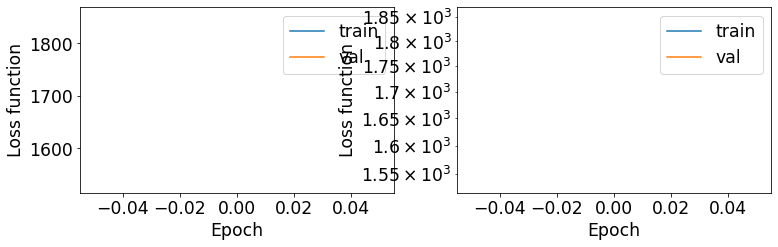

In [6]:
%%time

import plotting_functions as plf
importlib.reload(plf)

log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=(10, 20))
early_stop_callback = tf.keras.callbacks.EarlyStopping(patience=5, verbose=1)
callbacks =  [tensorboard_callback]

epochs=1
history = model.fit(train_dataset.batch(16).take(100), 
                    epochs=epochs,
                    verbose = 1,
                    workers = 3,
                    use_multiprocessing = True,
                    validation_data = test_dataset.batch(16).take(100),
                    #callbacks=callbacks
                    )
plf.plotTrainHistory(history)

current_time = datetime.now().strftime("%Y_%b_%d_%H_%M_%S")
print("Training start. Current Time =", current_time)

job_dir = "training/{epochs:04d}_"+current_time
model.save(job_dir, save_format='tf')

model.summary()
tf.keras.utils.plot_model(
    model, to_file="fig_png/model.png",
    show_shapes=True, show_dtype=False, show_layer_names=True,
    rankdir="TB", expand_nested=False,
    dpi=96, layer_range=None,
    show_layer_activations=True, show_trainable=False)

## Model performance on training data.

Fill Pandas DataFrame with true and response values.

2023-05-05 10:52:40.635656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-05 10:54:12.923551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


CPU times: user 2min 32s, sys: 4.54 s, total: 2min 37s
Wall time: 1min 42s


,GEN_StartPosX,GEN_StartPosY,GEN_StartPosZ,GEN_StopPosX_Part1,GEN_StopPosY_Part1,GEN_StopPosZ_Part1,GEN_StopPosX_Part2,GEN_StopPosY_Part2,GEN_StopPosZ_Part2,RECO_StartPosX,RECO_StartPosY,RECO_StartPosZ,RECO_StopPosX_Part1,RECO_StopPosY_Part1,RECO_StopPosZ_Part1,RECO_StopPosX_Part2,RECO_StopPosY_Part2,RECO_StopPosZ_Part2
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.304499,-0.000001,-41.256485,-2.474880,-0.283581,-41.664387,-0.266868,0.027927,-41.215309,0.378731,-0.172818,-41.042267,-2.288989,-0.165886,-41.226837,-0.165740,-0.154987,-40.940048
std,57.844269,0.000212,27.417728,82.588356,52.129395,31.853554,58.158783,5.481820,32.200211,57.522758,0.064137,27.465588,82.375343,51.384926,32.006744,57.903893,5.421267,32.256279
min,-99.993942,-0.000367,-66.358521,-198.368713,-95.828873,-75.571777,-110.298683,-13.632059,-66.387604,-105.979256,-0.369921,-68.930008,-195.996841,-98.782890,-76.256996,-110.958488,-10.517776,-69.051880
25%,-50.279261,-0.000185,-62.029361,-61.894854,-45.032720,-66.387604,-50.924095,-4.630929,-66.387604,-50.208026,-0.216728,-61.866098,-62.321678,-44.129463,-66.159590,-50.762490,-4.786791,-66.182379
50%,0.556943,-0.000002,-57.771076,-1.958492,-1.235388,-66.387604,0.835808,0.127130,-65.945175,0.546922,-0.171971,-57.739065,-1.984066,-2.431858,-64.680931,0.575670,0.116359,-64.747368
75%,50.265734,0.000185,-21.277271,57.608350,44.454007,-16.719201,49.530128,4.679375,-16.569233,50.286148,-0.131541,-20.968316,57.479446,43.773209,-16.382049,49.569899,4.478459,-16.219184
max,99.999573,0.000367,28.928123,186.112488,96.017113,39.225578,113.179268,15.065087,39.333450,113.116226,0.024659,30.354216,184.276108,97.074959,39.211456,111.424225,10.158971,40.402222


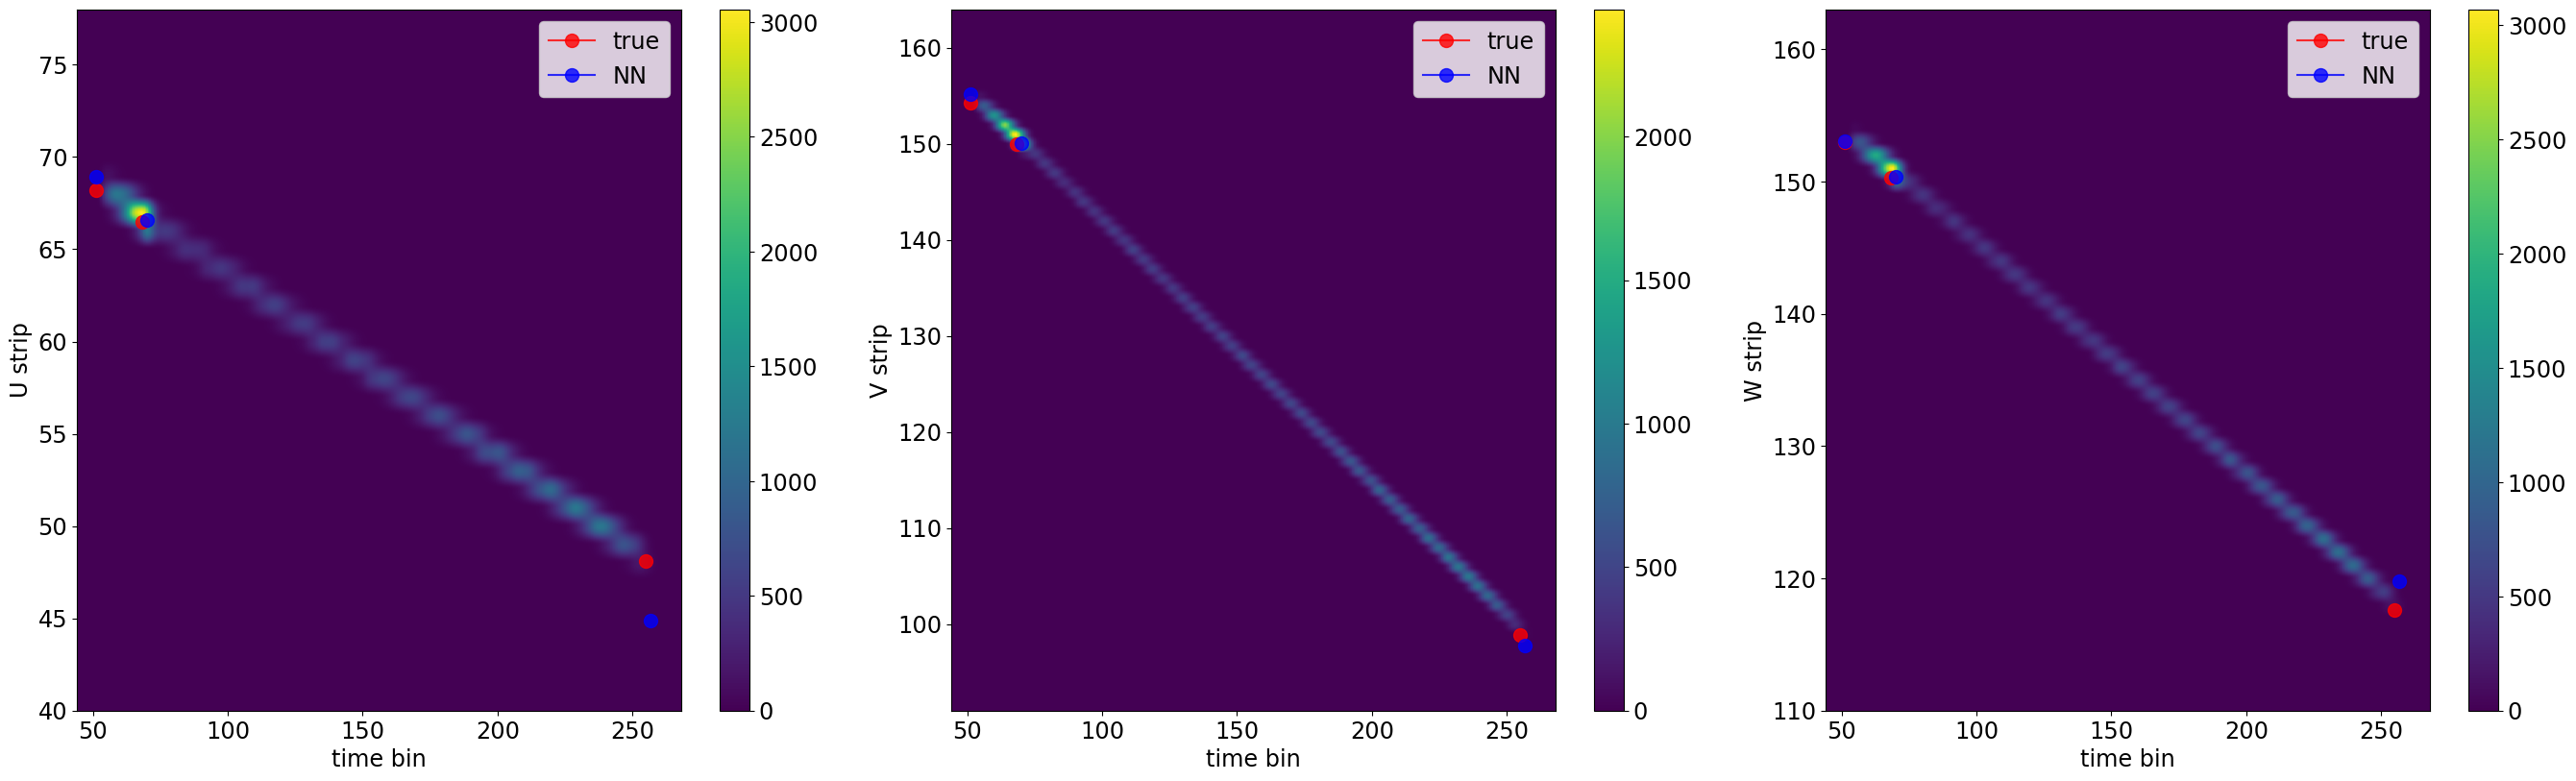

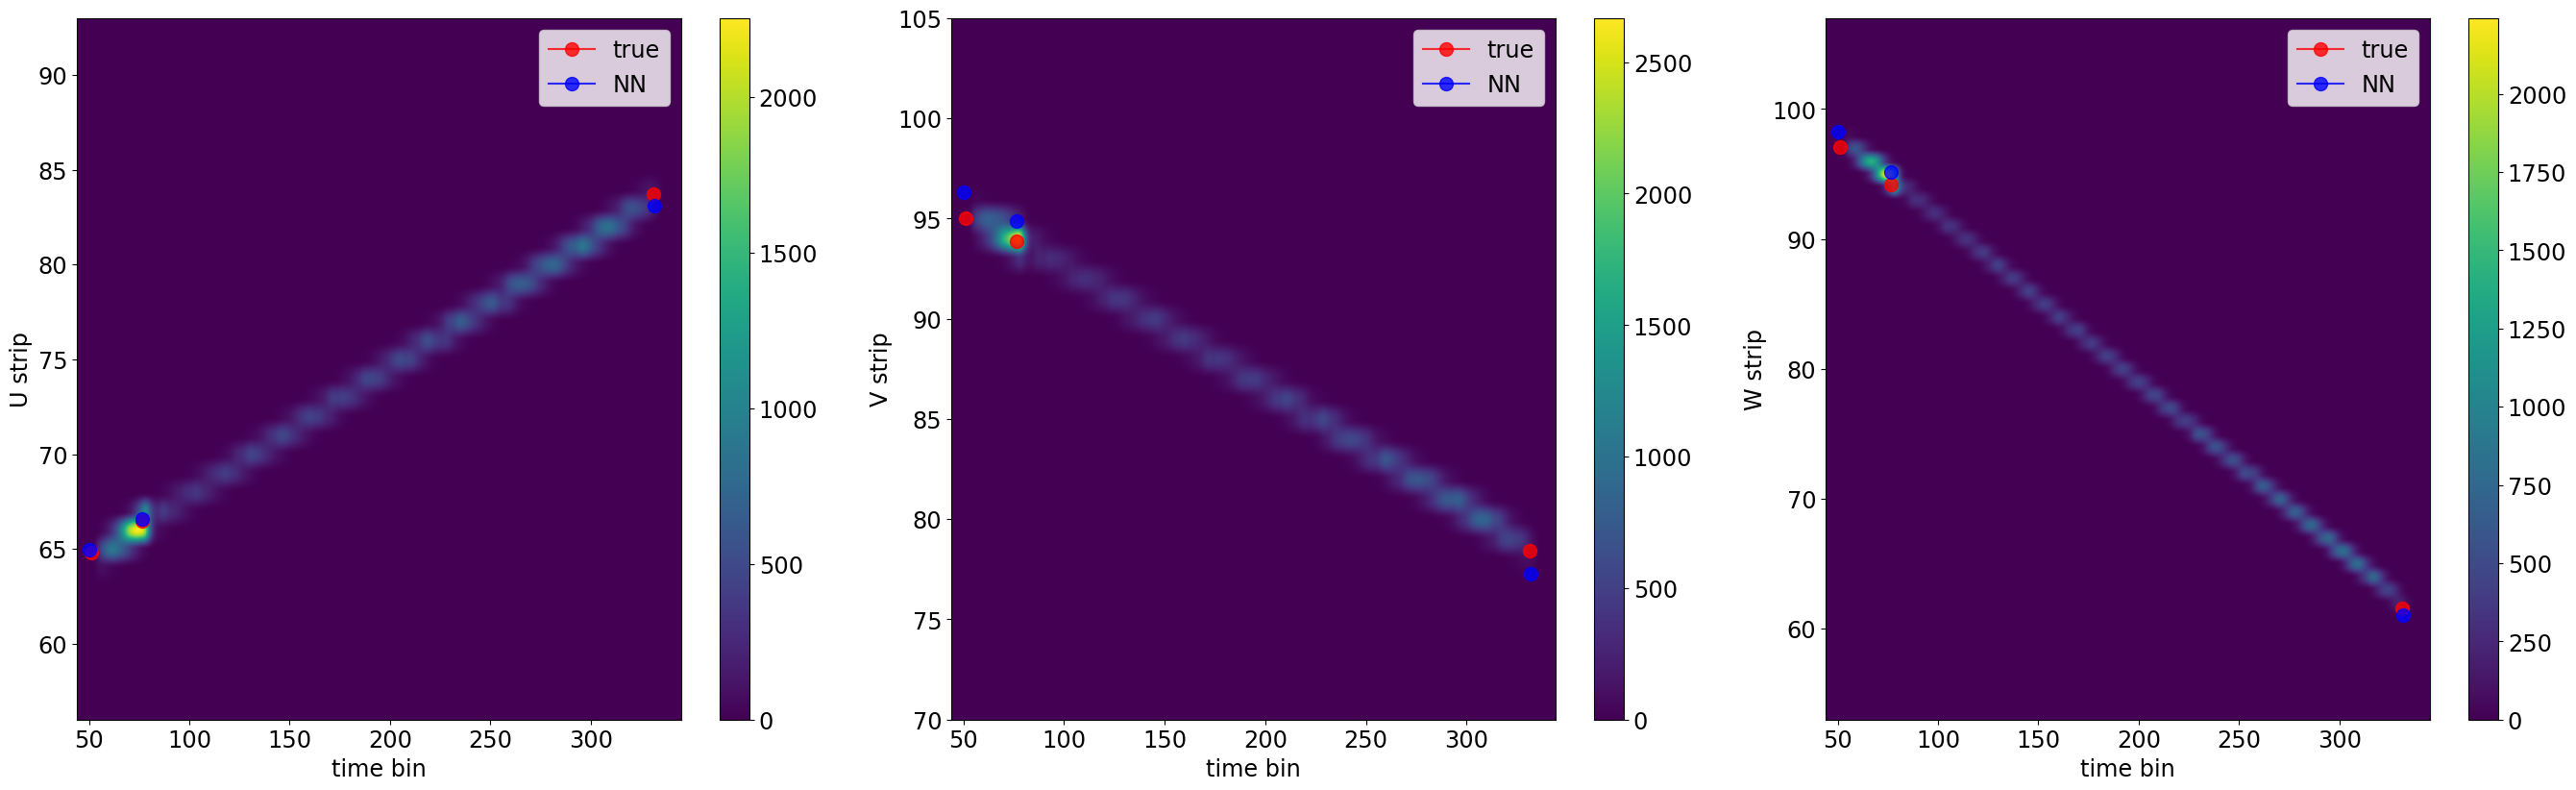

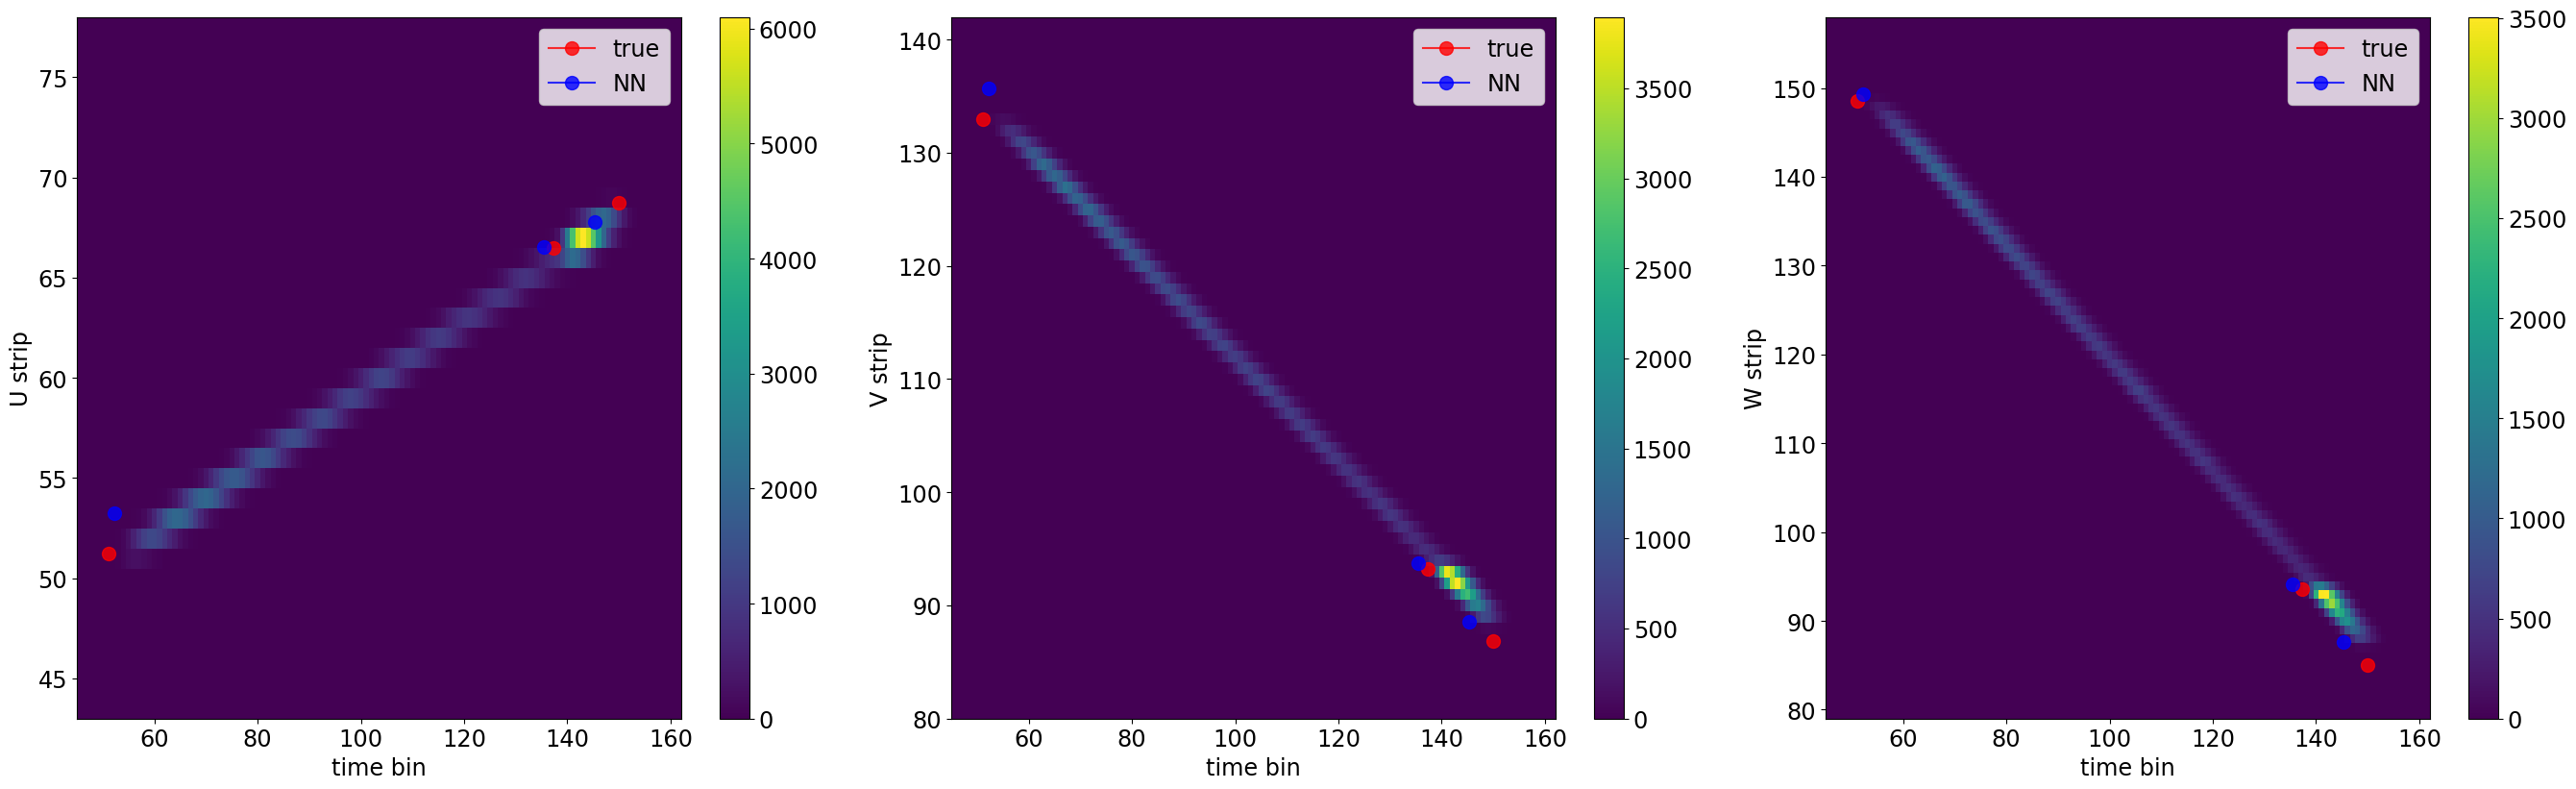

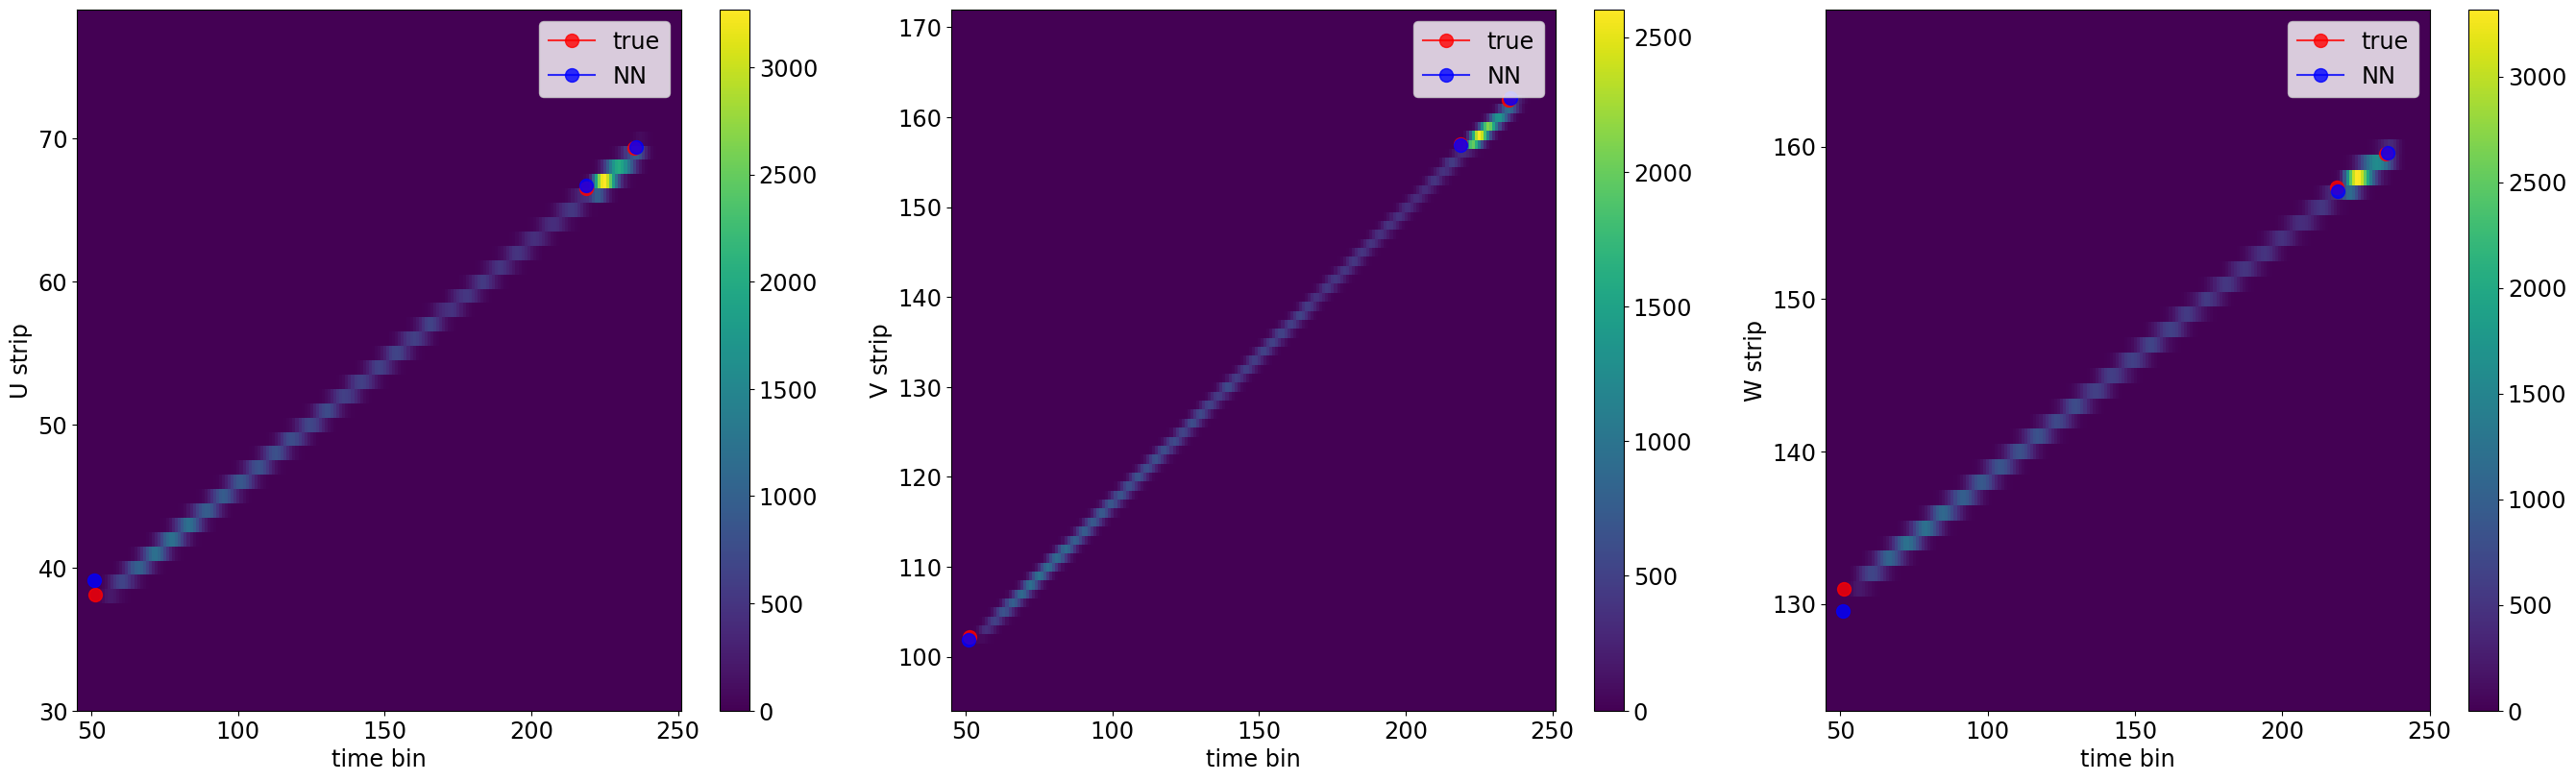

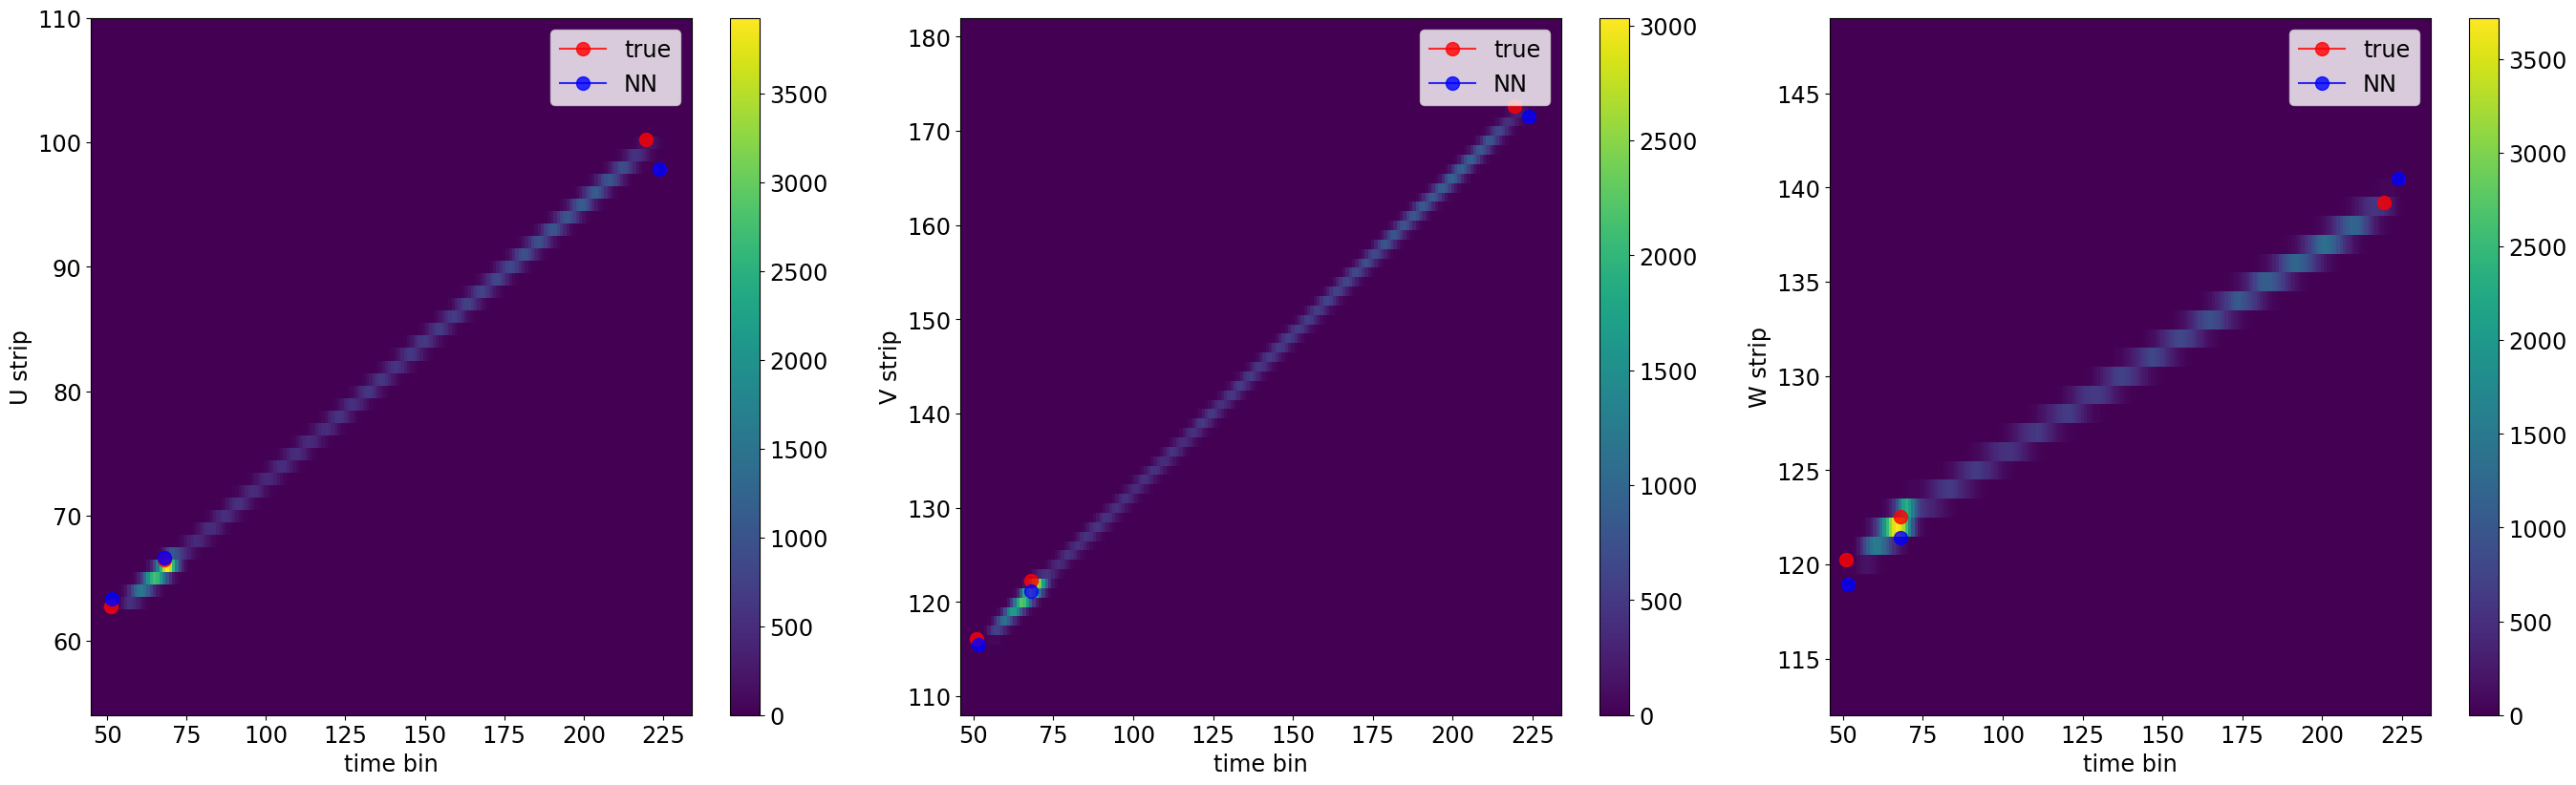

In [14]:
%%time
import utility_functions as utils
importlib.reload(utils)

model_path = "./training/2023_Apr_28_16_58_32/"
model_path = "/scratch_hdd/akalinow/ELITPC/PythonAnalysis/training/2023_May_02_23_51_30/"
model = tf.keras.models.load_model(model_path)

df = utils.df

for aBatch in test_dataset.batch(1).take(10000): 
    df = utils.fillPandasDataset(aBatch, df, model)     
    
for aBatch in test_dataset.batch(1).take(5):
    plf.plotEvent(aBatch, model=model)

df.describe()    

### Resolution plots

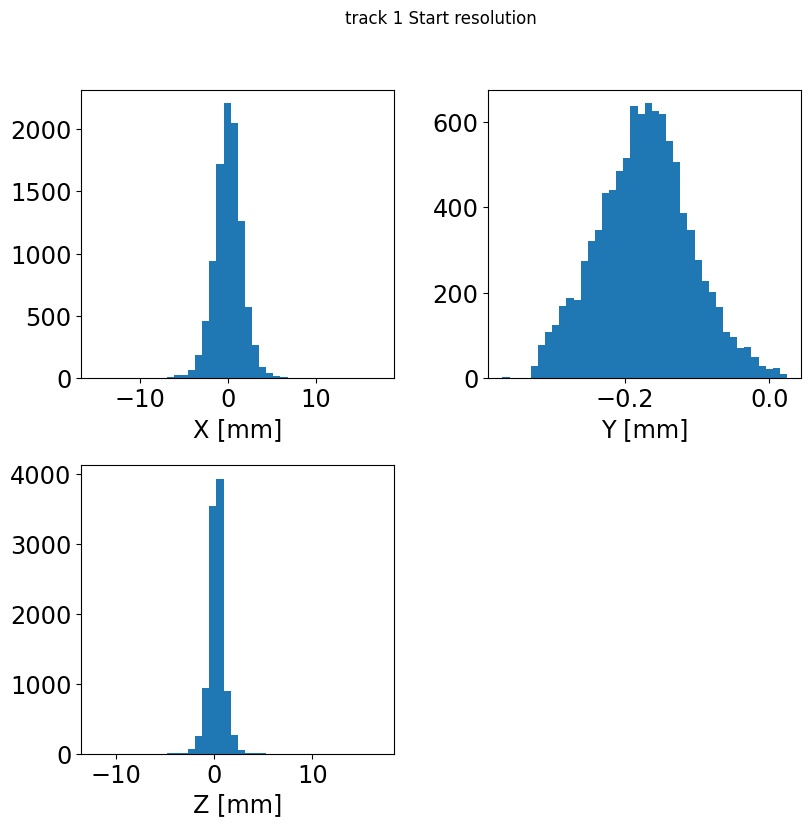

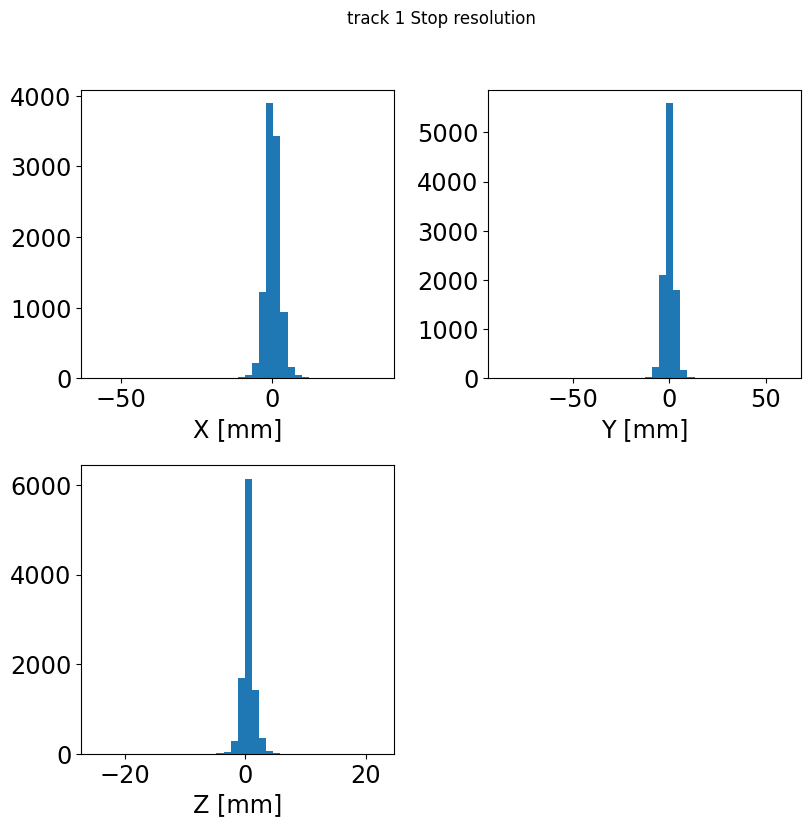

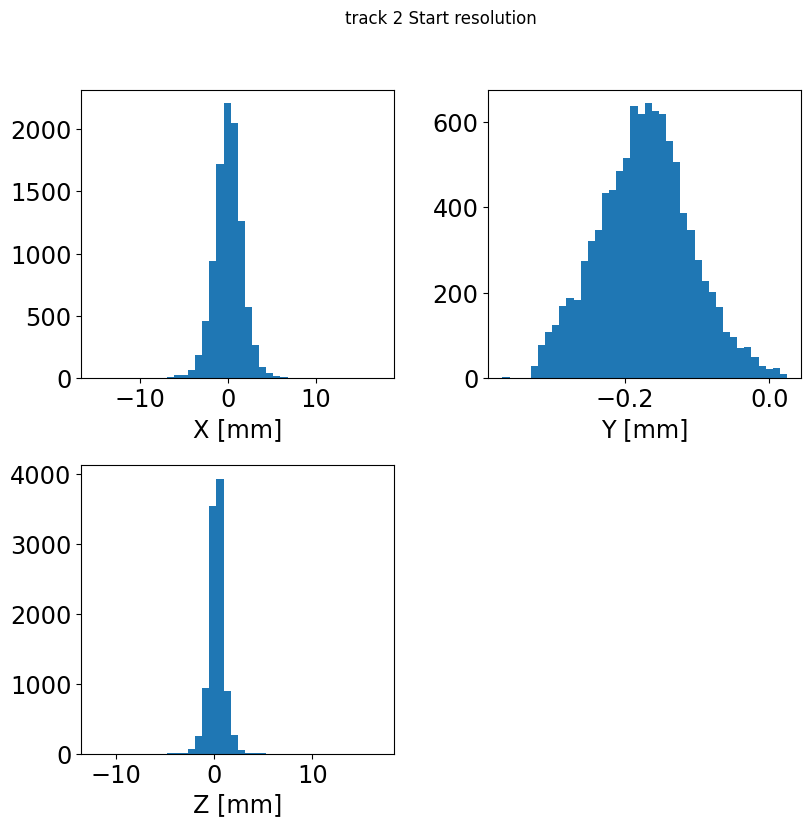

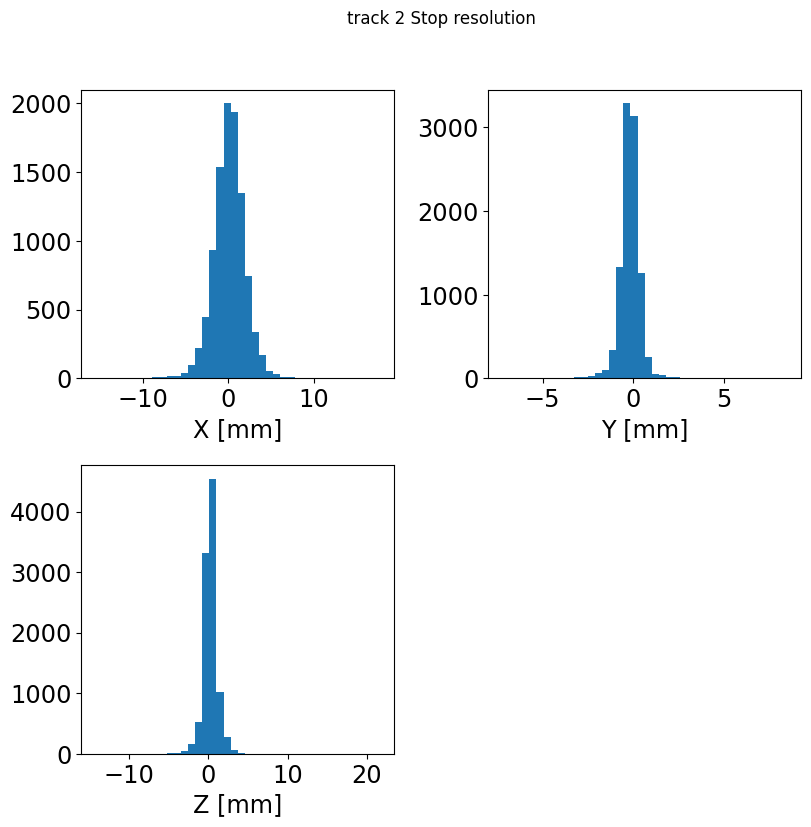

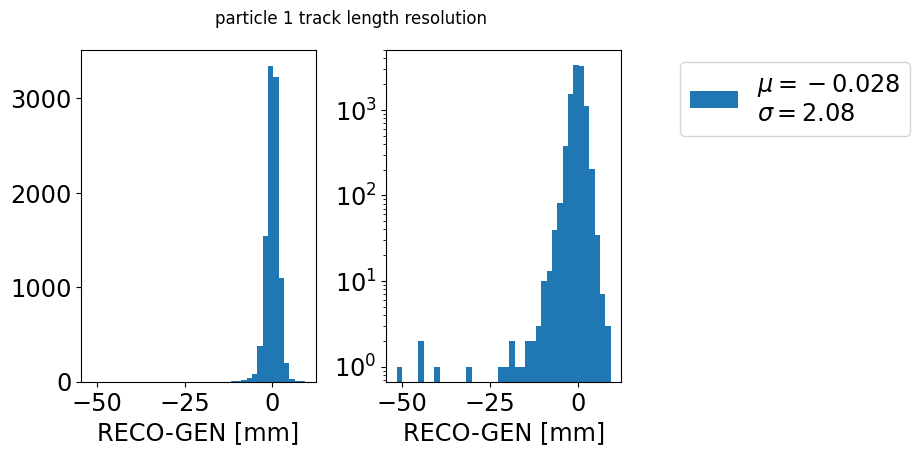

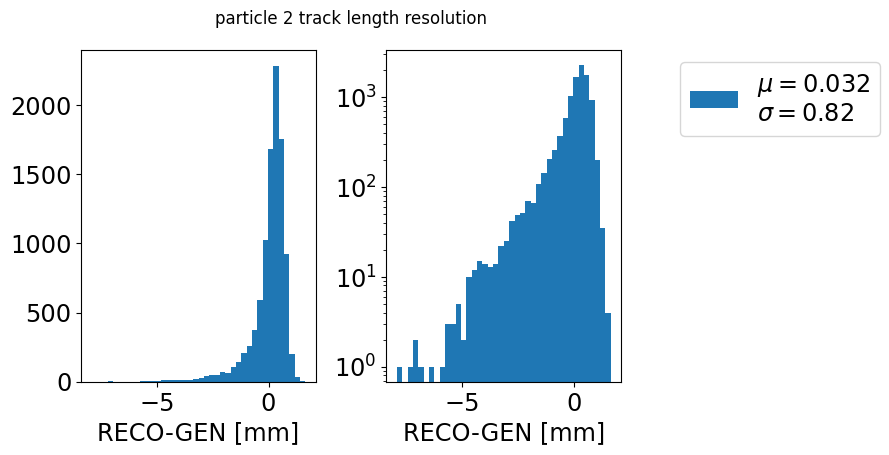

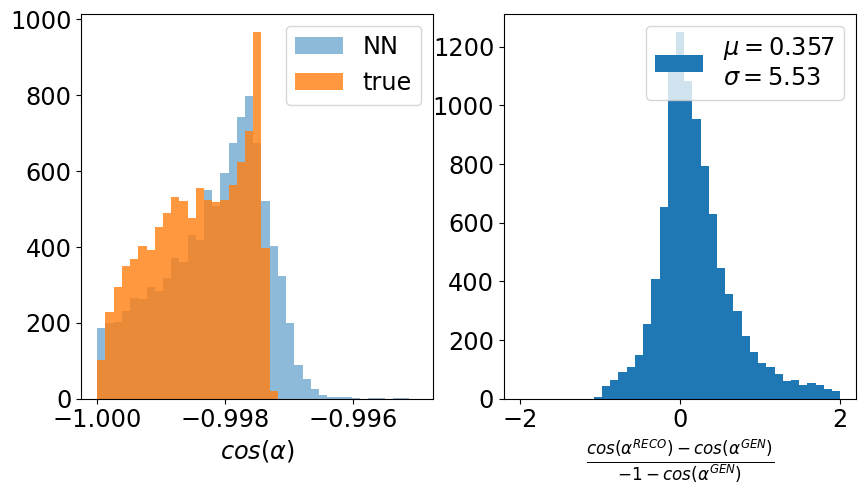

In [15]:
import plotting_functions as plf
importlib.reload(plf)

#plf.controlPlots(df)
plf.plotEndPointRes(df=df, edge="Start", partIdx=1)
plf.plotEndPointRes(df=df, edge="Stop", partIdx=1)

plf.plotEndPointRes(df=df, edge="Start", partIdx=2)
plf.plotEndPointRes(df=df, edge="Stop", partIdx=2)

plf.plotLengthPull(df, partIdx=1)
plf.plotLengthPull(df, partIdx=2)
plf.plotOpeningAngleCos(df)

       GEN_StartPosX  GEN_StartPosY  GEN_StartPosZ  GEN_StopPosX_Part1  \
count    5151.000000    5151.000000    5151.000000         5151.000000   
mean        2.352382      -0.000009     -40.806641            0.098146   
std        56.949478       0.000209      27.217770           80.884254   
min       -99.834755      -0.000367     -66.343277         -195.561005   
25%       -47.389492      -0.000189     -61.558878          -56.445883   
50%         4.183890      -0.000015     -57.930828           -1.397365   
75%        51.549217       0.000174     -18.576483           60.792608   
max        99.965805       0.000367      28.239874          182.630020   

       GEN_StopPosY_Part1  GEN_StopPosZ_Part1  GEN_StopPosX_Part2  \
count         5151.000000         5151.000000         5151.000000   
mean            -0.070210          -37.964825            1.726945   
std             49.801468           32.949398           57.441433   
min            -95.034149          -72.625381         -11

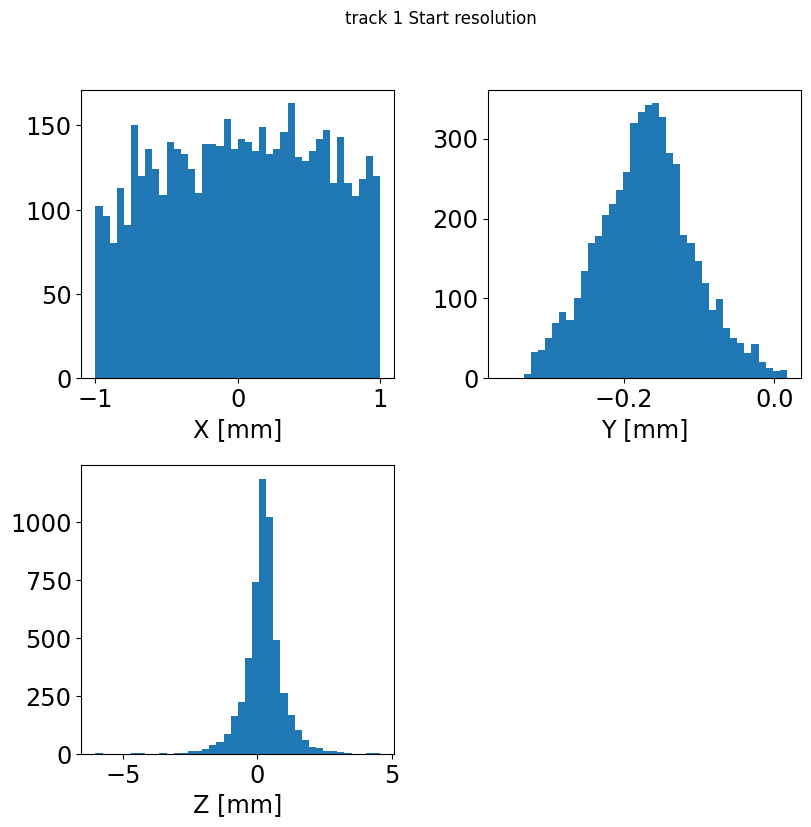

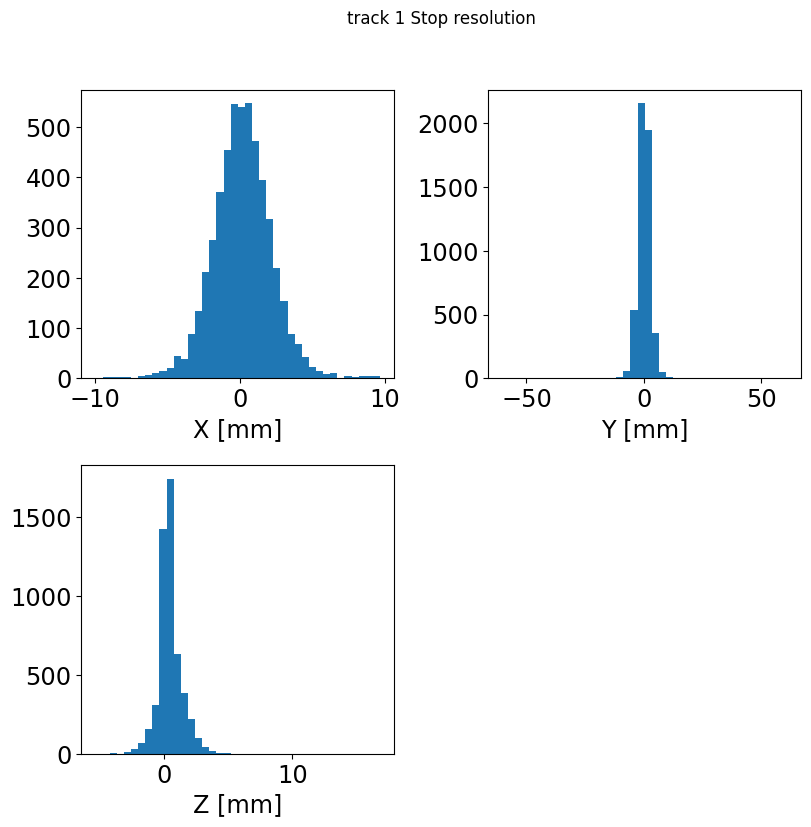

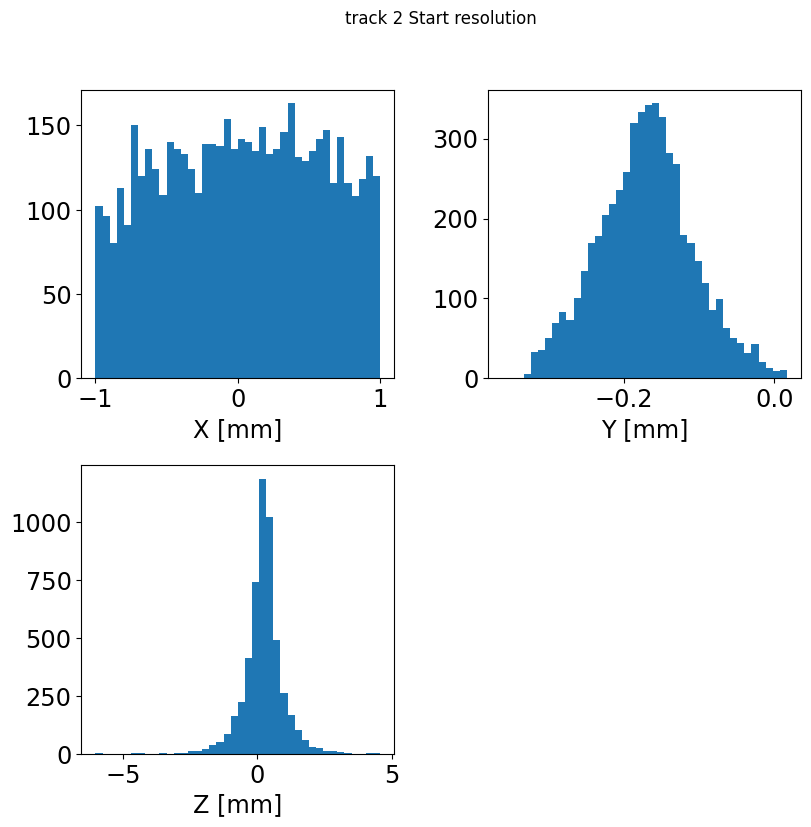

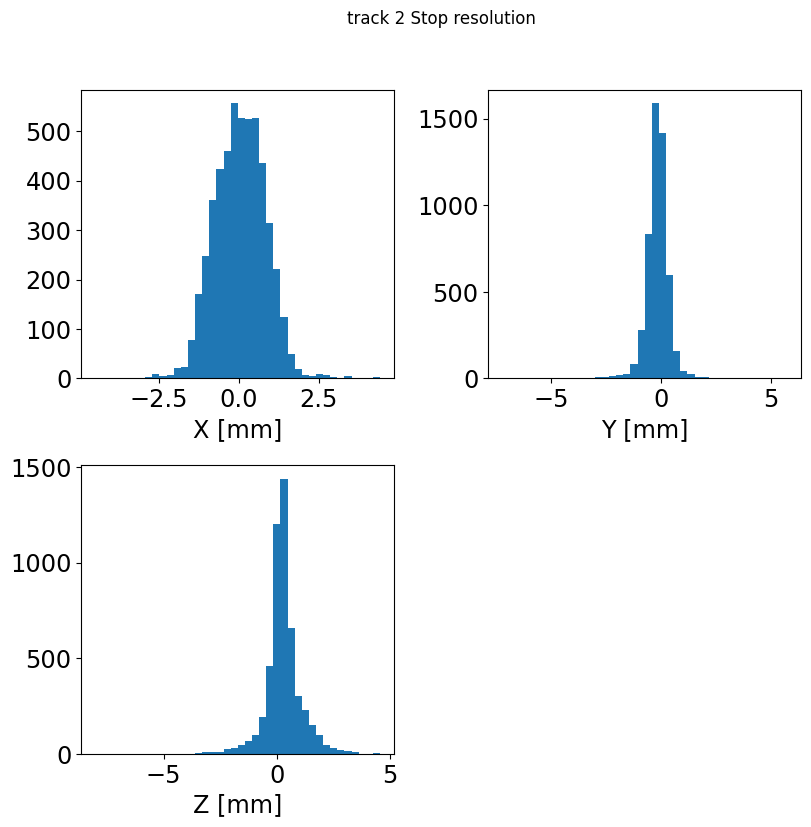

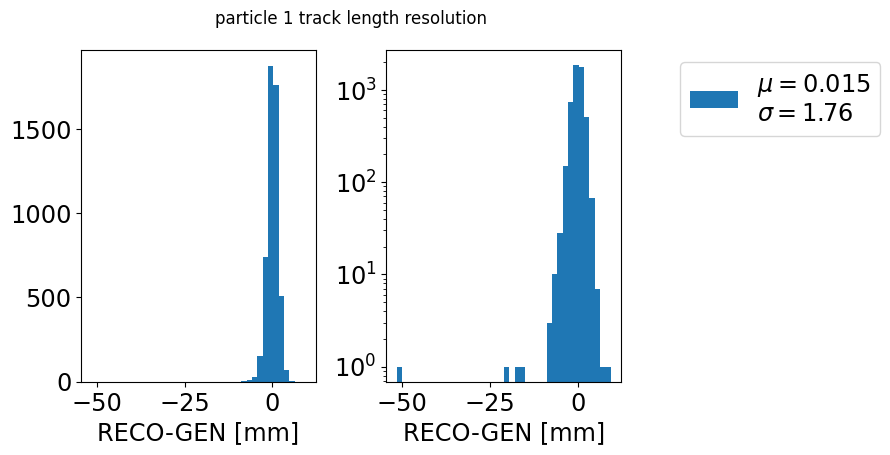

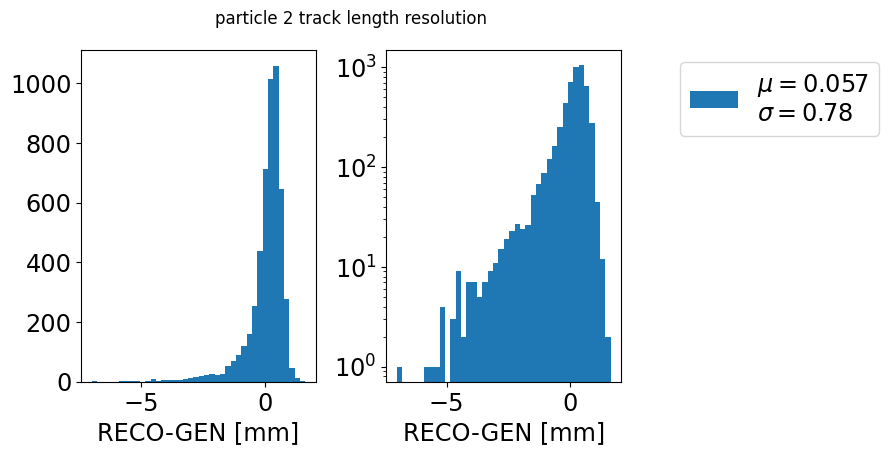

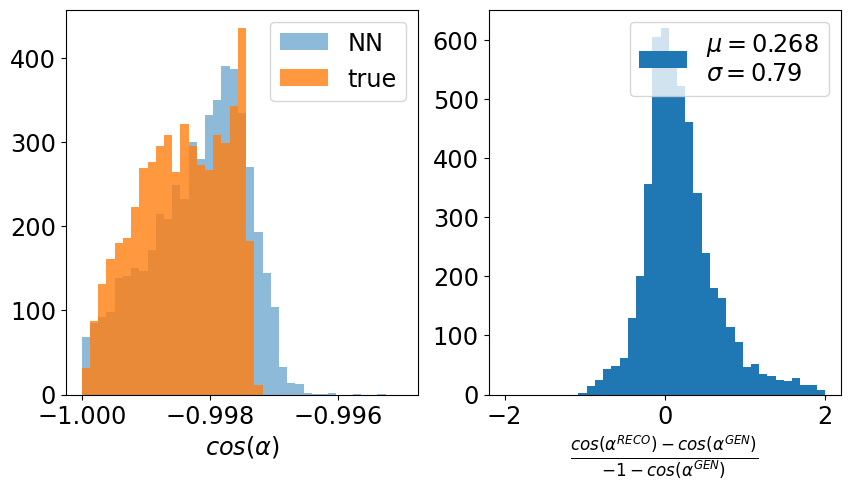

In [18]:
mask = np.abs(df["GEN_StartPosX"] - df["RECO_StartPosX"])<1
df_filtered = df[mask]

mask = np.abs(df_filtered["GEN_StartPosY"] - df_filtered["RECO_StartPosY"])<1
df_filtered = df_filtered[mask]

mask = np.abs(df_filtered["GEN_StopPosX_Part1"] - df_filtered["RECO_StopPosX_Part1"])<10
df_filtered = df_filtered[mask]

print(df_filtered.describe())

plf.plotEndPointRes(df=df_filtered, edge="Start", partIdx=1)
plf.plotEndPointRes(df=df_filtered, edge="Stop", partIdx=1)

plf.plotEndPointRes(df=df_filtered, edge="Start", partIdx=2)
plf.plotEndPointRes(df=df_filtered, edge="Stop", partIdx=2)

plf.plotLengthPull(df_filtered, partIdx=1)
plf.plotLengthPull(df_filtered, partIdx=2)
plf.plotOpeningAngleCos(df_filtered)